In [ ]:
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.patches as patches
import os
plt.rcParams['font.family'] = 'Times New Roman'
np.random.seed(42)

In [ ]:
fileName = 'processDailyData3.pkl'  # 路径
filePath = '/content/'  # 路径下的文件

file = filePath + fileName
with open(file, 'rb') as f:
    data:pd.DataFrame = pickle.load(f)

In [ ]:
file_path = '/content/No.4_clean_I.csv'
data = pd.read_csv(file_path)

In [ ]:
data.describe()
# data.columns
data.shape

(138, 6)

In [ ]:
print(data)

            ds          y      diff  diff_outlier  diff_outlier_filled  \
0   2024-01-11  70.583962       NaN           NaN                  NaN   
1   2024-01-12  70.564222 -0.019740     -0.019740            -0.019740   
2   2024-01-13  70.529746 -0.034476     -0.034476            -0.034476   
3   2024-01-14  70.485228 -0.044518           NaN            -0.005782   
4   2024-01-15  70.272807 -0.212421           NaN             0.010344   
..         ...        ...       ...           ...                  ...   
134 2024-05-24  70.097762 -0.020592     -0.020592            -0.020592   
135 2024-05-25  70.078796 -0.018967     -0.018967            -0.018967   
136 2024-05-26  70.074617 -0.004179     -0.004179            -0.004179   
137 2024-05-27  70.071057 -0.003560     -0.003560            -0.003560   
138 2024-05-28  70.070113 -0.000944     -0.000944            -0.000944   

     y_corrected  
0      70.583962  
1      70.564222  
2      70.529746  
3      70.523964  
4      70.534308

## 无预处理 + 无微调
先直接利用ds和y，看不经过预处理和微调，其预测的效果如何。

将数据按照8：2，分割训练集和测试集

In [ ]:
# 取出数据
#df_ds_y = data[["ds", "y_corrected"]].copy()
df_ds_y = data[["ds", data.columns[1]]].copy()
df_ds_y.columns = ["ds", "y"]

# 确保 'ds' 是时间格式
df_ds_y['ds'] = pd.to_datetime(df_ds_y['ds'])



df_ds_y

,ds,y
0,2024-01-11,142.842874
1,2024-01-12,142.840522
2,2024-01-13,142.864779
3,2024-01-14,142.904144
4,2024-01-15,142.998887
...,...,...
133,2024-05-23,142.904194
134,2024-05-24,142.904330
135,2024-05-25,142.899776
136,2024-05-26,142.896440


In [ ]:
# 按时间划分训练集和测试集
train_size = int(len(df_ds_y) * 0.8 )  # 前 80% 作为训练集
train_data = df_ds_y.iloc[:train_size]
test_data = df_ds_y.iloc[train_size:]

# 打印训练集和测试集的大小
print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")
print(train_data['ds'])

训练集大小: 110
测试集大小: 28
0     2024-01-11
1     2024-01-12
2     2024-01-13
3     2024-01-14
4     2024-01-15
         ...    
105   2024-04-25
106   2024-04-26
107   2024-04-27
108   2024-04-28
109   2024-04-29
Name: ds, Length: 110, dtype: datetime64[ns]


In [ ]:
import torch
from torch.utils.data import Dataset

# 自定义时间序列数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, data,seq_length):
        """
        初始化函数
        :param data: 原始时间序列数据，通常是一个 NumPy 数组或 Pandas 列
        :param seq_length: 输入序列的长度
        """
        self.data = data['y'].values  # 提取时间序列值
        self.dates = data['ds']      # 提取日期列
        self.seq_length = seq_length
        self.time_features = self.generate_time_features(self.dates)
    def __len__(self):
        """
        数据集的总长度
        :return: 时间序列中可以切割出的样本数量
        """
        return len(self.data) - self.seq_length

    def generate_time_features(self, dates):
        """
        生成时间特征 (sin/cos 编码)
        :param dates: 时间列 (Pandas DatetimeIndex)
        :return: 时间特征矩阵 (NumPy 数组)
        """


        # 定义每个月的天数
        month_days = {
            1: 31,  # 1月
            2: 28,  # 2月（忽略闰年情况，可以根据需要扩展）
            3: 31,  # 3月
            4: 30,  # 4月
            5: 31,  # 5月
            6: 30,  # 6月
            7: 31,  # 7月
            8: 31,  # 8月
            9: 30,  # 9月
            10: 31, # 10月
            11: 30, # 11月
            12: 31  # 12月
        }
        df = pd.DataFrame({'ds': dates})
        df['month'] = df['ds'].dt.month  # 月份
        df['day'] = df['ds'].dt.day      # 日期

        # 周期性编码 (只基于月份和日期)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        # 根据每个月的天数计算 day_sin 和 day_cos
        df['days_in_month'] = df['month'].map(month_days)  # 根据月份映射每个月的天数
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / df['days_in_month'])
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / df['days_in_month'])

        # 返回时间特征矩阵
        return df[['month_sin', 'month_cos', 'day_sin', 'day_cos']].values

    def __getitem__(self, idx):
        """
        根据索引生成一个样本
        :param idx: 样本的起始位置
        :return: 输入序列 (past_values), 观测掩码 (past_observed_mask), 目标值 (future_values)
        """
        # 生成历史序列 (past_values)
        x = self.data[idx: idx + self.seq_length]
        # 生成未来目标值 (future_values)
        y = self.data[idx + self.seq_length]
        # 生成观测掩码
        mask = ~torch.isnan(torch.tensor(x, dtype=torch.float32))
        # 获取历史时间特征 (past_time_features)
        past_time_features = self.time_features[idx: idx + self.seq_length, :]
        future_length = 1
        future_time_features = self.time_features[idx + self.seq_length: idx + self.seq_length + future_length, :]

        return (
            torch.tensor(x, dtype=torch.float32),
            mask,
            torch.tensor(y, dtype=torch.float32).unsqueeze(-1),
            torch.tensor(past_time_features, dtype=torch.float32),
            torch.tensor(future_time_features, dtype=torch.float32)
        )


In [ ]:
seq_length =  20# 更新序列长度为

# 使用更新的序列长度生成训练集和测试集样本
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

# 检查数据集大小
print(f"训练集样本数: {len(train_dataset)}")
#print(f"测试集样本数: {len(test_dataset)}")

# 打印样本信息
# print(f"数据集总样本数: {len(train_dataset)}")
# x, mask, y , past_fea, future_fea= train_dataset[1]
# print(f"第一个样本的输入序列 (past_values): {x}")
# print(f"第一个样本的观测掩码 (past_observed_mask): {mask}")
# print(f"第一个样本的目标值 (future_values): {y}")
# print(f"第一个样本的过去特征 (past_time_features): {past_fea}")
# print(f"第一个样本的未来特征 (future_time_features): {future_fea}")
# x, mask, y , past_fea, future_fea= test_dataset[1]
# print(f"第一个样本的输入序列 (past_values): {x}")
# print(f"第一个样本的观测掩码 (past_observed_mask): {mask}")
# print(f"第一个样本的目标值 (future_values): {y}")
# print(f"第一个样本的过去特征 (past_time_features): {past_fea}")
# print(f"第一个样本的未来特征 (future_time_features): {future_fea}")

训练集样本数: 90


### 加载模型

In [ ]:
from torch.utils.data import DataLoader

# 构建数据加载器
batch_size = 8
#dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 查看一个批次
for batch in dataloader:
    past_values, past_observed_mask, future_values ,past_time_features ,future_time_features= batch
    print(f"批次输入序列 (past_values): {past_values.shape}")  # (batch_size, seq_length)
    print(f"批次观测掩码 (past_observed_mask): {past_observed_mask.shape}")  # (batch_size, seq_length)
    print(f"批次目标值 (future_values): {future_values.shape}")  # (batch_size, pred_length)
    print(f"批次过去特征 (past_time_features): {past_time_features.shape}")  # (batch_size, seq_length, num_features)
    print(f"批次未来特征 (future_time_features): {future_time_features.shape}")  # (batch_size, pred_length, num_features)
    break


批次输入序列 (past_values): torch.Size([8, 20])
批次观测掩码 (past_observed_mask): torch.Size([8, 20])
批次目标值 (future_values): torch.Size([8, 1])
批次过去特征 (past_time_features): torch.Size([8, 20, 4])
批次未来特征 (future_time_features): torch.Size([8, 1, 4])


In [ ]:
# Load model directly
from transformers import AutoModel,AutoformerConfig,AutoformerForPrediction

In [ ]:
config = AutoformerConfig.from_pretrained("MRNH/autoformer-ett-hourly")
config.prediction_length = 1
config.context_length = 9
config.label_length = config.prediction_length
config.moving_average  = 15
config.num_paraller_samples = 20
config.num_static_categorical_features = 0  # 禁用静态类别特征
config.num_static_real_features = 0  # 禁用静态实值特征
config.lags_sequence = [4,7,11]
model = AutoformerForPrediction(config)

In [ ]:
import torch.optim as optim

# 定义优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#from lion_pytorch import Lion
# 定义 Lion 优化器
#optimizer = Lion(model.parameters(), lr=1e-4)

Epoch 1, Batch 1, Loss: 5.408072471618652
Epoch 1, Batch 2, Loss: 4.674872875213623
Epoch 1, Batch 3, Loss: 4.648123741149902
Epoch 1, Batch 4, Loss: 4.929649353027344
Epoch 1, Batch 5, Loss: 4.844523906707764
Epoch 1, Batch 6, Loss: 4.408023357391357
Epoch 1, Batch 7, Loss: 5.236056327819824
Epoch 1, Batch 8, Loss: 4.410174369812012
Epoch 1, Batch 9, Loss: 4.334197998046875
Epoch 1, Batch 10, Loss: 4.389987945556641
Epoch 1, Batch 11, Loss: 4.4128265380859375
Epoch 1, Batch 12, Loss: 4.529947757720947
Epoch 1, Batch 13, Loss: 4.298356533050537
Epoch 1, Batch 14, Loss: 4.24327278137207
Epoch 1, Batch 15, Loss: 4.483525276184082
Epoch 1, Batch 16, Loss: 4.1144232749938965
Epoch 1, Batch 17, Loss: 4.061006546020508
Epoch 1, Batch 18, Loss: 4.5499796867370605
Epoch 1, Batch 19, Loss: 3.9063103199005127
Epoch 1, Batch 20, Loss: 4.253343105316162
Epoch 1, Batch 21, Loss: 4.266607761383057
Epoch 1, Batch 22, Loss: 4.116151332855225
Epoch 1, Batch 23, Loss: 3.7206966876983643
Epoch 1, Batch 2

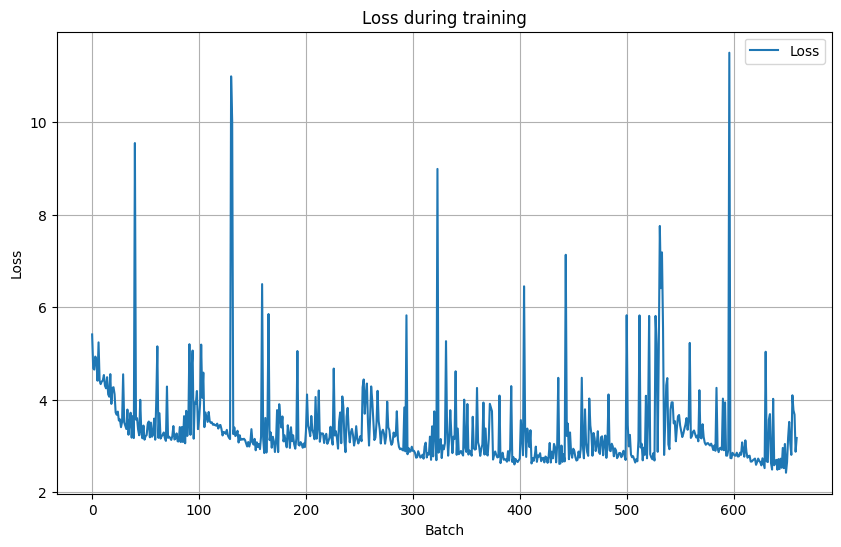

In [ ]:
import matplotlib.pyplot as plt
import torch

# 初始化变量以存储loss
losses = []
min_loss = float('inf')
best_model_state = None

# 模型训练
model.train()
for epoch in range(20):
    for batch_idx, batch in enumerate(dataloader):
        past_values, past_observed_mask, future_values, past_time_features, future_time_features = batch

        # 前向计算
        outputs = model(
            past_values=past_values,
            past_observed_mask=past_observed_mask,
            future_values=future_values,
            past_time_features=past_time_features,
            future_time_features=future_time_features
        )
        loss = outputs.loss

        # 保存loss
        losses.append(loss.item())

        # 打印训练进度
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.item()}")

        # 保存当前最小loss的模型
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_model_state = model.state_dict()  # 保存模型状态字典

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
        optimizer.step()

# 可视化loss值
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.legend()
plt.grid()
plt.show()




In [ ]:
# 保存loss最小的模型参数
torch.save(best_model_state, "bestmodel_1000.pkl")
print(f"Model with minimum loss ({min_loss}) saved")

Model with minimum loss (2.4186551570892334) saved


In [ ]:
def smooth_predictions(predictions, alpha=0.8):
    smoothed = torch.zeros_like(predictions)
    smoothed[0] = predictions[0]  # 初始化第一个值
    for t in range(1, len(predictions)):
        smoothed[t] = alpha * predictions[t] + (1 - alpha) * smoothed[t - 1]
    return smoothed


In [ ]:

config = AutoformerConfig.from_pretrained("MRNH/autoformer-ett-hourly")
config.prediction_length = 1
config.context_length = 9
config.label_length = config.prediction_length
config.moving_average  = 1
config.num_paraller_samples = 1
config.num_static_categorical_features = 0  # 禁用静态类别特征
config.num_static_real_features = 0  # 禁用静态实值特征
config.lags_sequence = [4,7,11]
config.target_distribution = "normal"
model = AutoformerForPrediction(config)
# 加载权重
model.load_state_dict(torch.load("/content/bestmodel_1000.pkl"))
model.eval()

<ipython-input-193-968c1f1bcdff>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/bestmodel_1000.pkl"))


AutoformerForPrediction(
  (model): AutoformerModel(
    (scaler): AutoformerMeanScaler()
    (encoder): AutoformerEncoder(
      (value_embedding): AutoformerValueEmbedding(
        (value_projection): Linear(in_features=9, out_features=1024, bias=False)
      )
      (embed_positions): AutoformerSinusoidalPositionalEmbedding(10, 1024)
      (layers): ModuleList(
        (0-1): 2 x AutoformerEncoderLayer(
          (self_attn): AutoformerAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=32, bias=True)
          (fc2): Line

In [ ]:
predictions = []
ground_truths = []
std = []
with torch.no_grad():
    for batch in dataloader:
        past_values, past_observed_mask, future_values, past_time_features, future_time_features = batch

        # 进行预测
        outputs = model.generate(
            past_values=past_values,
            past_observed_mask=past_observed_mask,
            past_time_features=past_time_features,
            future_time_features=future_time_features,
        )
        # 提取预测值
        # hidden_states = outputs.encoder_last_hidden_state  # 编码器隐藏状态
        # loc = outputs.loc
        # scale = outputs.scale
        # # 解码器可能返回标准化的预测值，因此需要反归一化
        # predicted_values = hidden_states[:, -1, :] * scale + loc
        # predictions.append(predicted_values.squeeze(-1))
        # ground_truths.append(future_values)
        mean_prediction = outputs.sequences.mean(dim=1)
        std_prediction = outputs.sequences.std(dim=1)
        std.append(std_prediction)
        print(mean_prediction)
        predictions.append(mean_prediction)
        ground_truths.append(future_values)




tensor([[143.3394],
        [143.4077],
        [144.5434],
        [142.4814],
        [143.9960],
        [145.7626],
        [145.7441],
        [147.6944]])


In [ ]:
predictions = torch.cat(predictions, dim=0)
ground_truths = torch.cat(ground_truths, dim=0)
predicted_std = torch.cat(std, dim=0)

In [ ]:
z_value = 1.96  # 对应 95% 置信区间
lower_bound = predictions - z_value * predicted_std  # 下界
upper_bound = predictions + z_value * predicted_std  # 上界

In [ ]:
smoothed_predictions = smooth_predictions(predictions, alpha=0.01) #平滑处理
predictions = smoothed_predictions
lower_bound = smooth_predictions(lower_bound, alpha=0.01)
upper_bound = smooth_predictions(upper_bound, alpha=0.01)

In [ ]:
print(predictions.size())
print(ground_truths.size())

torch.Size([22, 1])
torch.Size([22, 1])


In [ ]:
print(predictions)
print(ground_truths)

tensor([[143.6658],
        [144.4793],
        [142.1939],
        [142.7565],
        [141.2909],
        [139.9268],
        [141.1994],
        [142.2957],
        [137.5479],
        [138.9945],
        [139.9492],
        [138.3520],
        [141.0529],
        [139.2088],
        [139.4821],
        [140.8136],
        [142.2065],
        [140.5818],
        [141.3954],
        [143.7759],
        [144.7278],
        [144.7510]])
tensor([[142.4436],
        [142.4408],
        [142.4347],
        [142.4386],
        [142.4535],
        [142.4676],
        [142.4799],
        [142.4813],
        [142.4691],
        [142.4728],
        [142.4570],
        [142.4679],
        [142.4725],
        [142.4612],
        [142.4921],
        [142.4787],
        [142.4606],
        [142.4471],
        [142.4472],
        [142.4427],
        [142.4393],
        [142.4478]])


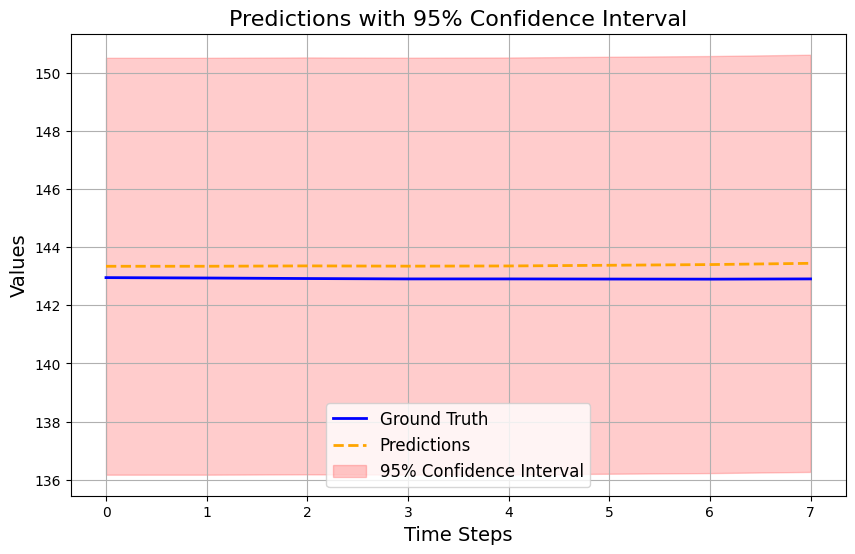

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 转换为 NumPy 数组
predictions_np = predictions.numpy()
ground_truths_np = ground_truths.numpy()

# 假设置信区间的上下界
# 这里以预测值的 0.05 范围作为置信区间的示例 (替换为你自己的计算逻辑)
confidence_interval = 0.05 * np.abs(predictions_np)  # 示例置信区间范围
upper_bound = predictions_np + confidence_interval
lower_bound = predictions_np - confidence_interval
# 创建时间步，假设每个数据点对应一个时间步
time_steps = range(len(predictions_np))
# 绘图
plt.figure(figsize=(10, 6))

# 绘制真实值和预测值
plt.plot(time_steps, ground_truths_np, label="Ground Truth", color="blue", linewidth=2)
plt.plot(time_steps, predictions_np, label="Predictions", color="orange", linestyle="--", linewidth=2)

# 绘制置信区间的阴影区域
plt.fill_between(time_steps, lower_bound, upper_bound, color="red", alpha=0.2, label="95% Confidence Interval")

# 设置 y 轴范围
#plt.ylim(69.5, 70)

# 添加标题和标签
plt.title("Predictions with 95% Confidence Interval", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=12)

# 显示网格
plt.grid(True)

# 显示图像
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(ground_truths_np, predictions_np)
mae = mean_absolute_error(ground_truths_np, predictions_np)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
